In [ ]:
!nvidia-smi

Tue Jan  4 11:43:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output/PID_train_100_mins.png .
!cp /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output/PID_train_data_100_mins.csv .

![](https://miro.medium.com/max/1400/1*S0rXIeO_VoUVOyrYHckUWg.gif)

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

# Loading Data

Index(['Q1', 'T1', 'Tsp'], dtype='object')


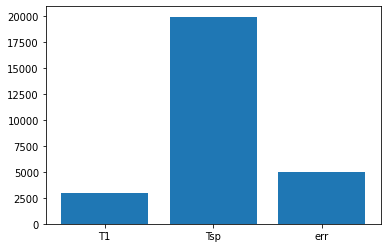

In [ ]:
# paths
gen_csv_file = "/content/PID_train_data_100_mins.csv"
mins = gen_csv_file.split("_")[-2]
model_path = f"/content/lstm_model_{mins}_mins.h5"
model_params_file_path = f"/content/lstm_model_params_{mins}_mins.pkl"
# Load training data
df = pd.read_csv(gen_csv_file)

print(df.columns)

# Create new feature: setpoint error
# Because, PID controller takes the error between temp. sensor and setpoint as the input
df['err'] = df['Tsp'] - df['T1']   # (SP - PV)

# Load possible features
# T1 -> PID output
# Tsp -> Set point
# err -> (Set point - PID Output (PV))
X = df[['T1','Tsp','err']]
# y -> heater output
y = np.ravel(df[['Q1']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
plt.bar(x=X.columns,height=fit.scores_);

# Hyper-params

In [ ]:
# Hyperparameters for model
window = 15
layers = 4
batch_size = 100
drop = 0.1
units = 100
# (100, 15, 3)

# Preprocessing

In [ ]:
X = df[['Tsp','err']].values
y = df[['Q1']].values

# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.2,shuffle=False)

# LSTM model

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00080: early stopping


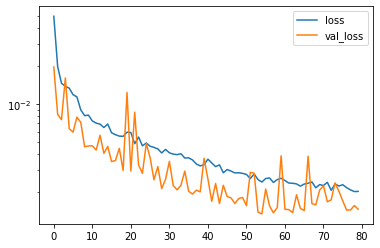

In [ ]:
model = Sequential()

if layers == 1:
    model.add(LSTM(units=units, 
                   input_shape=(Xtrain.shape[1],Xtrain.shape[2])
                  )
             )
    model.add(Dropout(rate=drop))
else:
    # First layer specifies input_shape and returns sequences
    model.add(LSTM(units=units, 
                   return_sequences=True, 
                   input_shape=(Xtrain.shape[1],Xtrain.shape[2])
                  )
             )
    model.add(Dropout(rate=drop))
    # Middle layers return sequences
    for i in range(layers-2):
        model.add(LSTM(units=units,return_sequences=True))
        model.add(Dropout(rate=drop))
    # Last layer doesn't return anything
    model.add(LSTM(units=units))
    model.add(Dropout(rate=drop))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=25
                  )

result = model.fit(Xtrain, ytrain, 
                   verbose=0, 
                   validation_split=0.2,
                   callbacks = [es,TqdmCallback(verbose=1)],
                   batch_size=batch_size,
                   epochs=350)

# Show results and save
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()0

model.save(model_path)

In [ ]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s_x
model_params['yscale'] = s_y
model_params['window'] = window

pickle.dump(model_params, open(model_params_file_path, 'wb'))

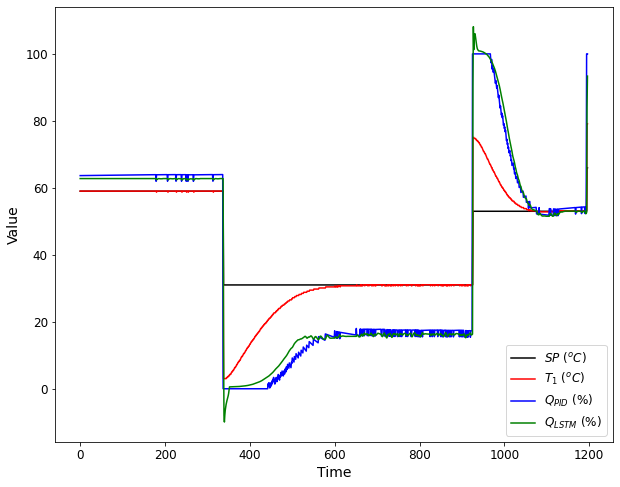

In [ ]:
# Predict using LSTM
yp_s = model.predict(Xtest)

# Unscale data
Xtest_us = s_x.inverse_transform(Xtest[:,-1,:])
ytest_us = s_y.inverse_transform(ytest)
yp = s_y.inverse_transform(yp_s)

# Derive Tsp (setpoint) and T1 (sensor) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]

# Plot SP, PID response, and LSTM response
plt.figure(figsize=(10,8))
plt.plot(sp,'k-',label='$SP$ $(^oC)$')
plt.plot(pv,'r-',label='$T_1$ $(^oC)$')
plt.plot(ytest_us,'b-',label='$Q_{PID}$ (%)')
plt.plot(yp,'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=12,loc='lower right')
plt.xlabel('Time',size=14)
plt.ylabel('Value',size=14)
plt.xticks(size=12)
plt.yticks(size=12);

In [ ]:
!cp {model_path} /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output
!cp {model_params_file_path} /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output